In [2]:
import sys
from sklearn import svm

%matplotlib inline

sys.path.append("/Users/maithoma/work/github/bsr/analysis/")
sys.path.append("/Users/maithoma/work/github/bsr/experiment/")
sys.path.append("/Users/maithoma/work/github/brainlib/")

#sys.path.append("/Users/maithoma/work/python/")
#from tm_python_lib import *

import Levenshtein
from scipy import stats as S

try:
    reload(bsrAnalysisLib)
    #reload(tasks)
except:
    import bsrAnalysisLib
    #import tasks
    
from bsrAnalysisLib import *
#from tasks import *

rootDir = "/Users/maithoma/work/github/bsr/analysis/"

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def smooth(x,beta):
 """ kaiser window smoothing """
 window_len=21
 # extending the data at beginning and at the end
 # to apply the window at the borders
 s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
 w = np.kaiser(window_len,beta)
 y = np.convolve(w/w.sum(),s,mode='valid')
 return y[10:len(y)-10]

In [4]:
def generateJointPDF(lwVector,sVector,plot=False):
    lwBins = np.arange(1,20+1)
    #sBins = np.linspace(-5,5,10)
    H, yedges, xedges = np.histogram2d(lwVector,sVector,bins=(lwBins,60))
    #print len(xedges),len(yedges)
    H = H/np.sum(H)
    
    if plot:
        #fig, ax = pl.subplots(figsize=(12,6))
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        pl.imshow(H, cmap=pl.cm.Blues, extent=extent, aspect='auto', interpolation='nearest',origin=[0,0])

    pl.xlabel("entropy")
    pl.ylabel("word length")
    return {'H' : H,'sBins' : xedges , 'lwBins' : lwBins}

def randPickWordLength(s,pdfDic):

    if not (s >= pdfDic['sBins'][0] and s < pdfDic['sBins'][-1]):
        print "input entropy out of boundaries"
        return
    else:
        index = np.argwhere(pdfDic['sBins'] >= s)[0]    
        pdf = pdfDic['H'].transpose()[index]/np.sum(pdfDic['H'].transpose()[index])
        cdf = np.cumsum(pdf)
        #print cdf
        
        rand = np.random.rand()
        index = np.argwhere(rand <= cdf)[0]
        #print "rand number: %.2f, index: %s, word length: %s"%(rand,index[0],pdfDic['lwBins'][index][0])
        return pdfDic['lwBins'][index][0]
    
def randPickEntropy(wordlength,pdfDic):

    if not (wordlength >= pdfDic['sBins'][0] and wordlength < pdfDic['sBins'][-1]):
        #print "word length input out of boundaries %s"%wordlength
        return 0
    elif np.sum(pdfDic['H'][np.argwhere(pdfDic['lwBins'] >= wordlength)[0]]) == 0:
        return 0
    else:
        index = np.argwhere(pdfDic['lwBins'] >= wordlength)[0]
        
        pdf = pdfDic['H'][index]/np.sum(pdfDic['H'][index])
        cdf = np.cumsum(pdf)
        #print cdf
        
        rand = np.random.rand()
        try:
            index = np.argwhere(cdf >= rand)[0]
            #print "rand number: %.2f, index: %s, word length: %s"%(rand,index[0],pdfDic['lwBins'][index][0])
            return pdfDic['sBins'][index][0]
        except:
            print "blah"
            return 0
    
def cossim(v1,v2):
    #return S.spearmanr(v1,v2)[0]
    return np.sum(v1*v2) / (np.sqrt(np.sum(v1**2))*np.sqrt(np.sum(v2**2)))

def decipher(sEntropy,lWordFootPrint,pdfDic,length = 20,mcsteps = 100):
    m = np.zeros([mcsteps,length])
    scores = {}
    
    for i in range(mcsteps):
        for s,sx in enumerate(sEntropy[:length]):
            
            m[i,s] = randPickWordLength(sx,pdfDic)
            #if sx < -3:
                #m[i,s] = randPickWordLength(sx,pdfDic)
            #    m[i,s] = 3
            
            
            for k,v in lWordFootPrint.items():
                
                c = (m[i,1:s+1] > -1)*(v[1:s+1] < 5)
                #print c
                score = cossim(v[1:s+1][c],m[i,1:s+1][c])
                #print "%s: %.2f"%(k,score)
                
                try:
                    scores[k][i,s] = score
                except:
                    scores[k] = np.zeros_like(m)
                    scores[k][i,s] = score
            #print "\n"
            
    return m,scores


def pullOut(token,treatment):
    J = allData[token]['J']
    Jlist = allData[token]['Jlist']
    words = np.array(J[Jlist[treatment]]['exp']['words'])[:-1]
    lWords = np.array([len(word) for word in words])
    sEntropy = np.array(J[Jlist[treatment]]['exp']['normalized_entropy'][:-1])
    sPlus = np.array([np.sum(sEntropy[i-5:i+5]) for i,ix in enumerate(sEntropy)])
    return {'words' : words, 'lWords' : lWords, 'sEntropy': sEntropy, 'sPlus': sPlus, 'treatment':Jlist[treatment],'text':words[1]}

In [5]:
tokens = ['8db55','68cdc','92647','ac3ef','f62ff','29979','d6dbd','2cd39','85d6e',
          '5f615','94460','b527b','9a02b','74712','46dfb','ad3fb','474f1',
          'b9817','35d1b','251a6','5534e']

allData = {}

for token in tokens:
    J,Jlist = retrieveExperiment(token)
    allData[token] = {'J':J,'Jlist' : Jlist}

In [24]:
tokens = ['8db55','68cdc','92647','ac3ef','f62ff','29979','d6dbd','2cd39','85d6e',
          '5f615','94460','b527b','9a02b','74712','46dfb','ad3fb','474f1',
          'b9817','35d1b','251a6','5534e']

In [2]:
print len(tokens)

21


In [6]:
pattern = pullOut('8db55',5)

In [19]:
print pattern['lWords'][:35]
print pattern['words'][:35]

[ 1  2  3  4  2  6  3  4 12  2  5  4  2  4  5  4  6  3  2  3  4  4  2  4  5
  4  3  7  8  3 10  6 10  3  6]
[u'x' u'We' u'all' u'know' u'we' u'should' u'use' u'less' u'electricity.'
 u'It' u'would' u'save' u'us' u'some' u'money' u'each' u'month,' u'and'
 u'in' u'the' u'long' u'run,' u'it' u'just' u'might' u'save' u'the'
 u'planet,' u'reducing' u'our' u'collective' u'carbon' u'footprint.' u'But'
 u'sadly,']


blah config
blah config
blah config
blah config
blah config
blah config
blah config
blah config
blah config


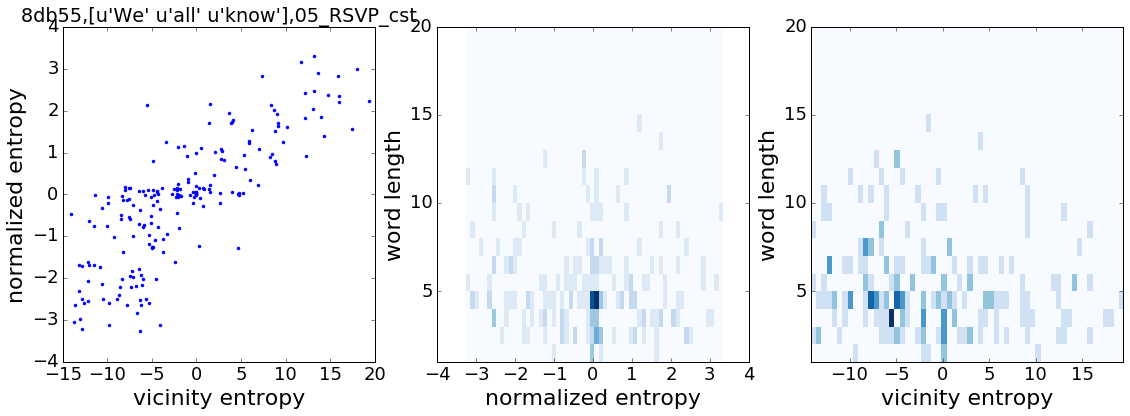

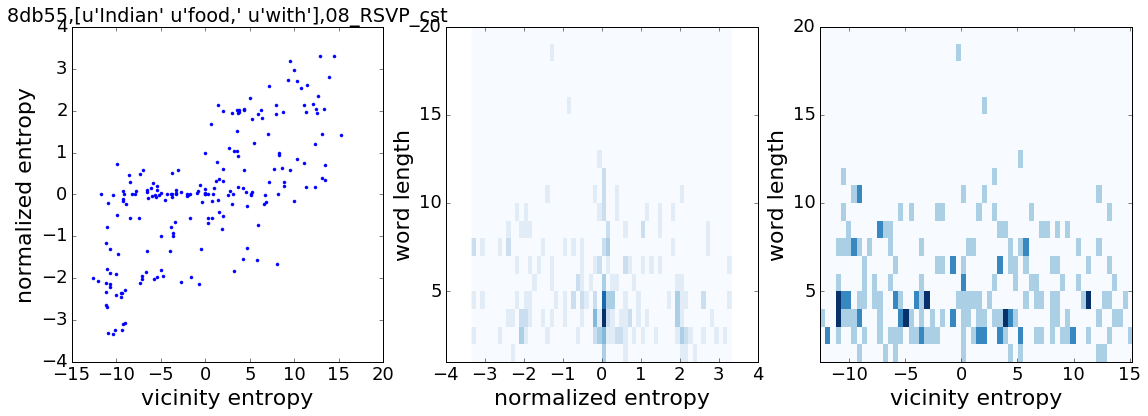

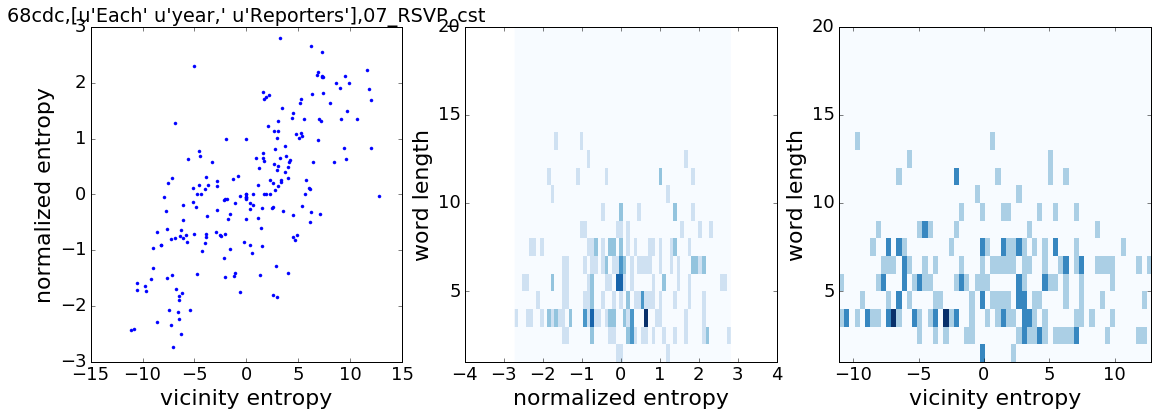

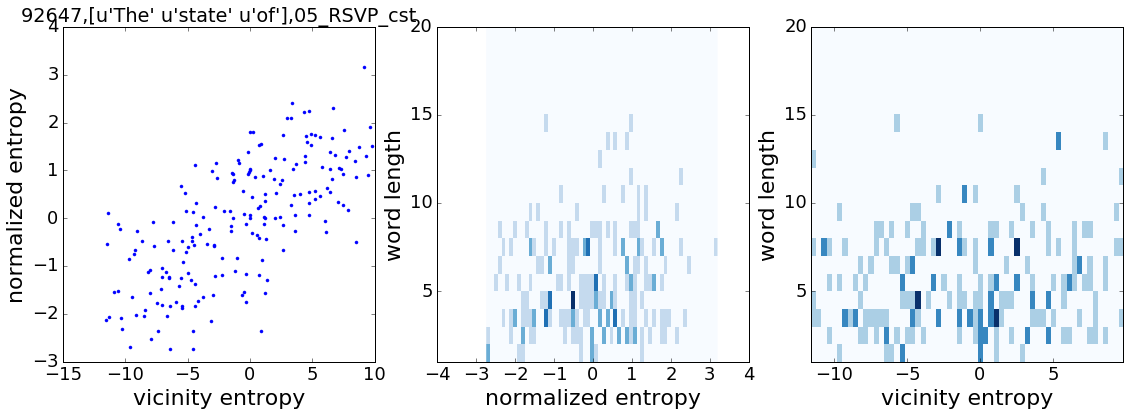

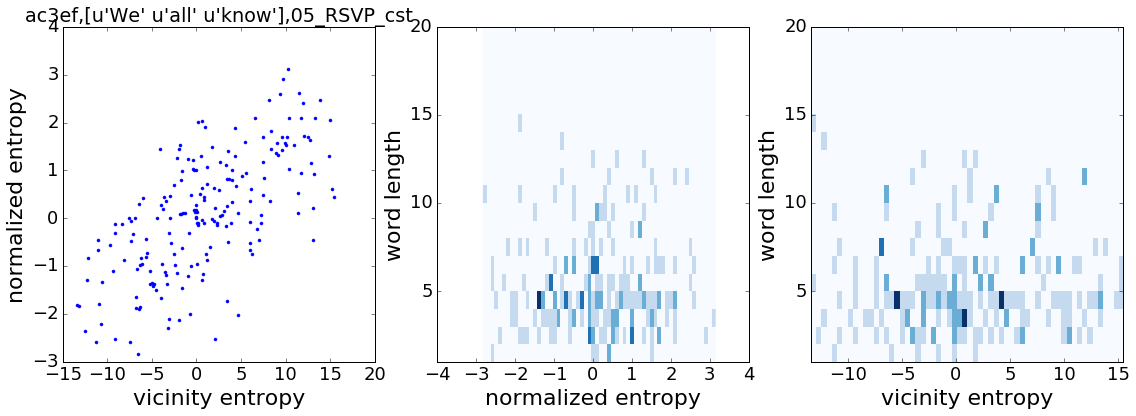

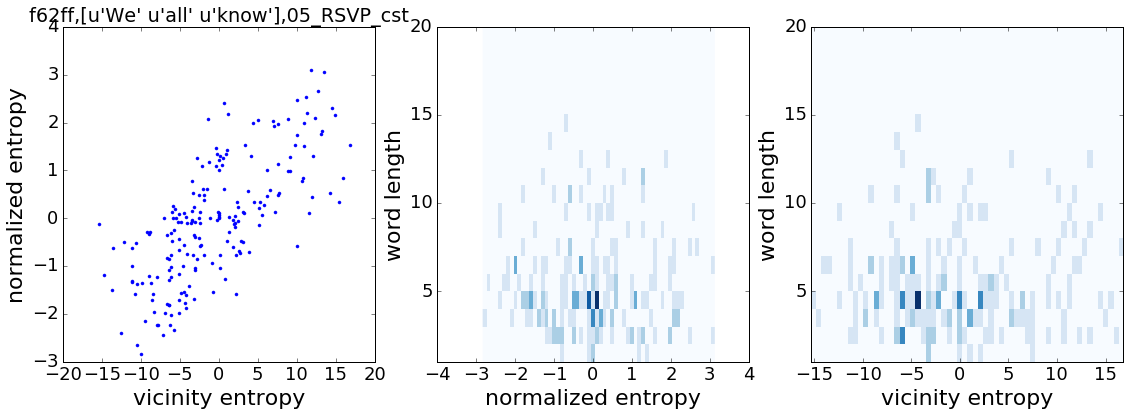

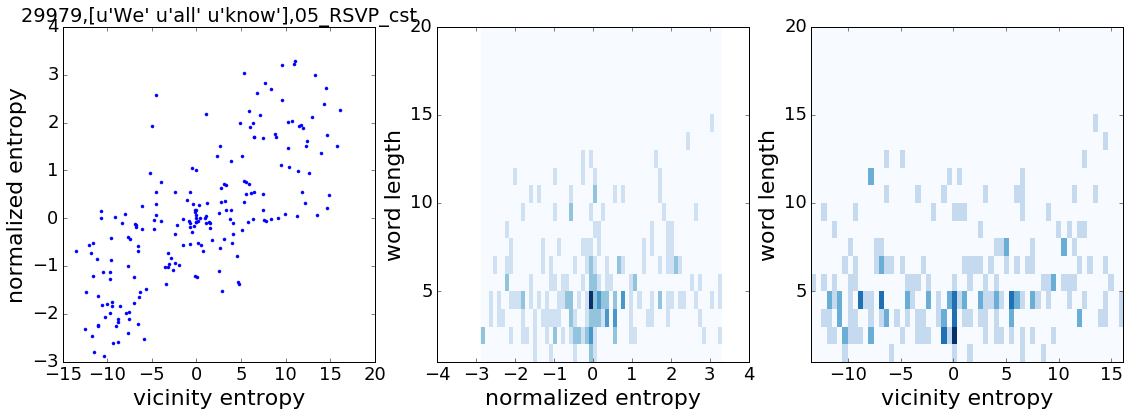

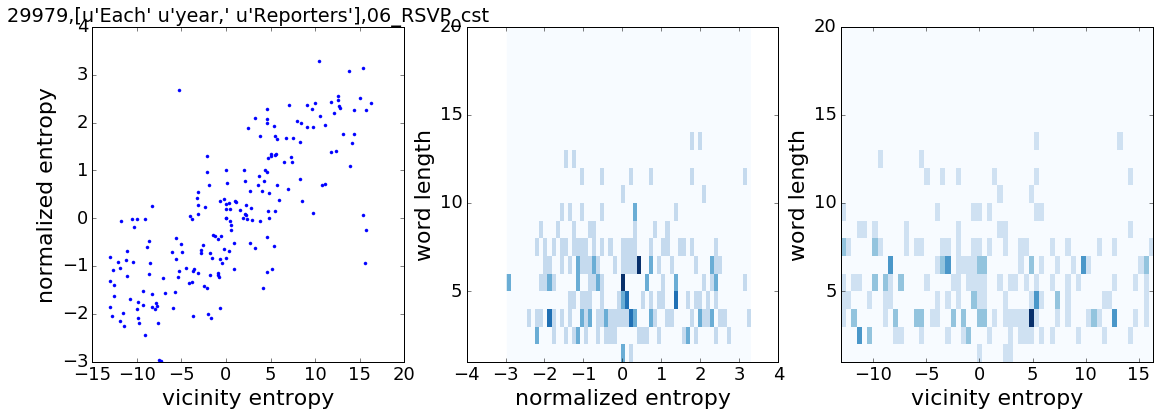

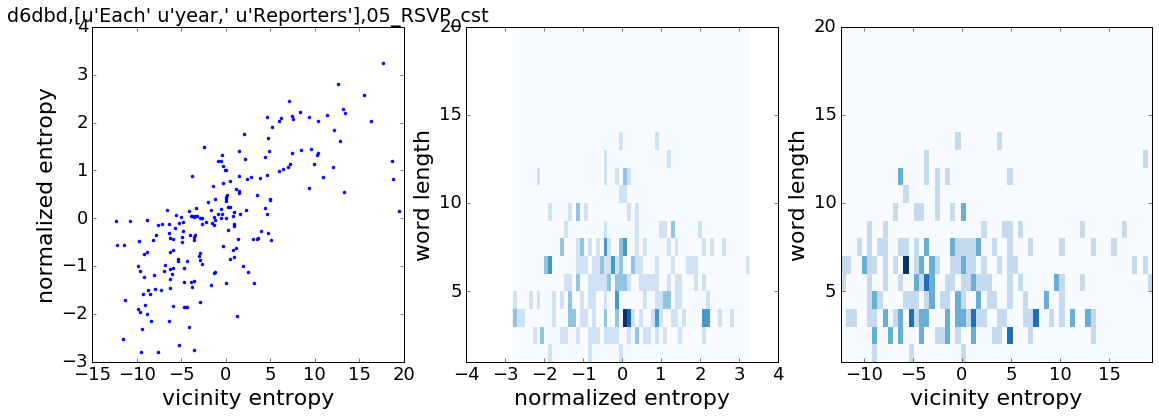

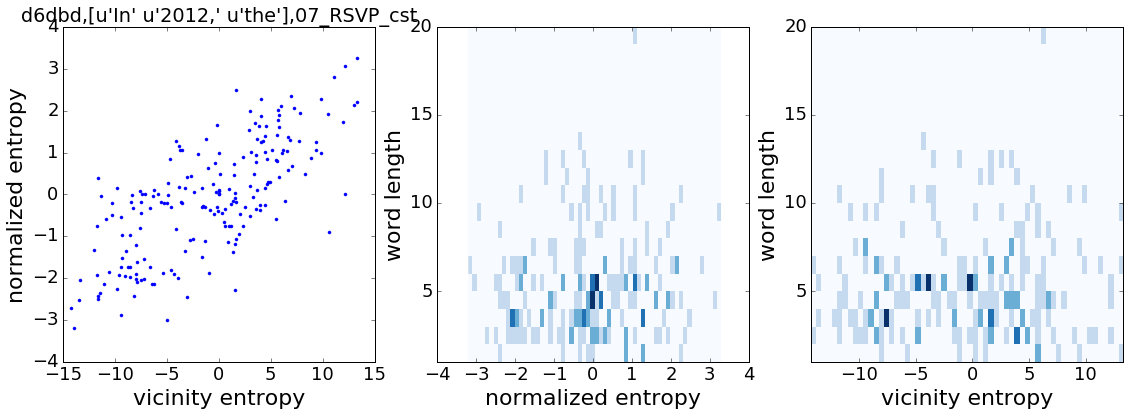

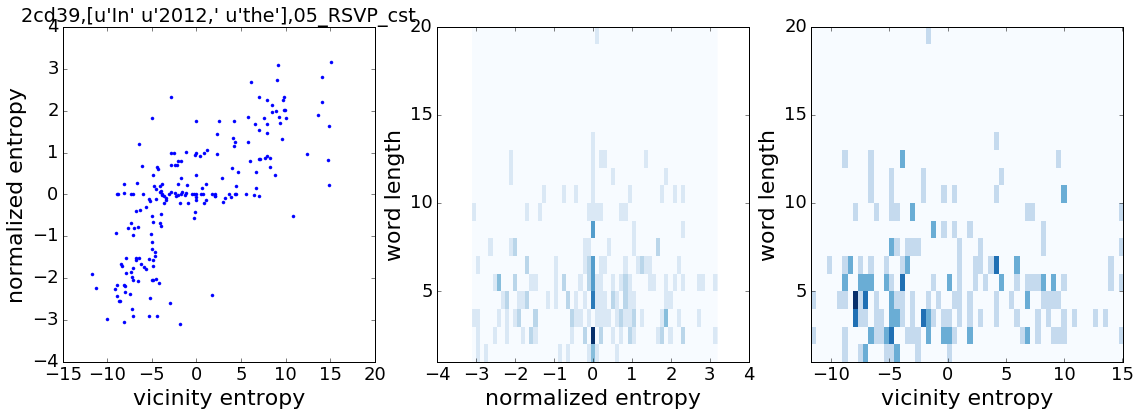

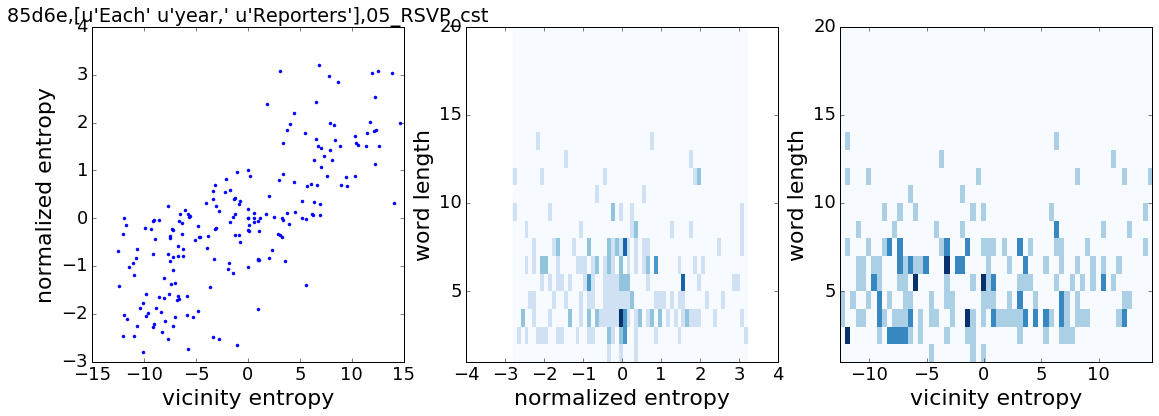

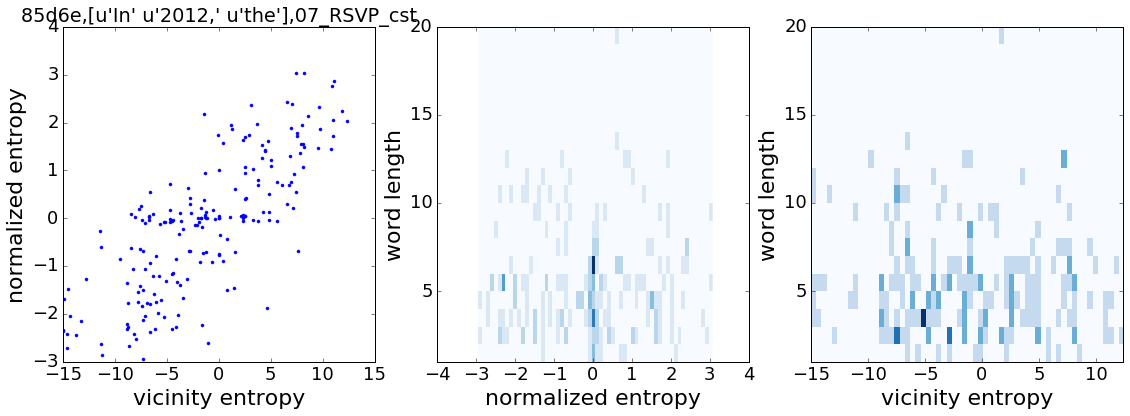

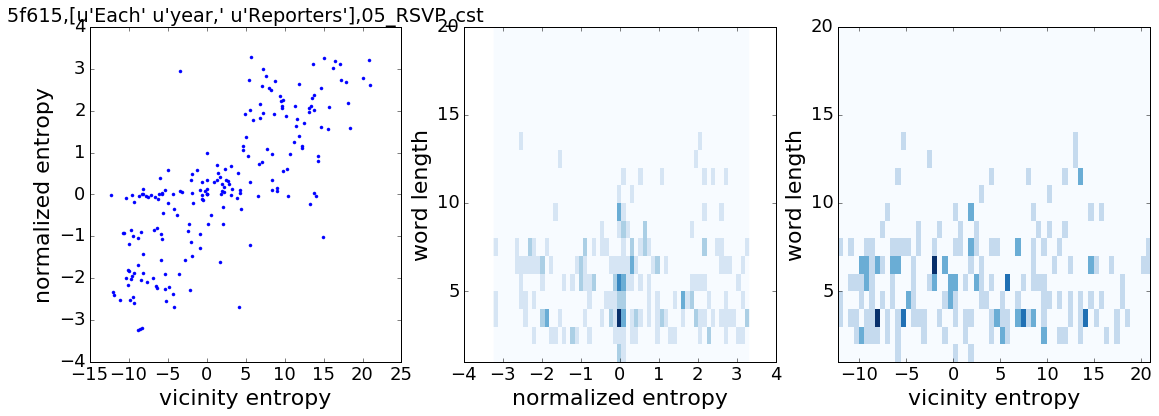

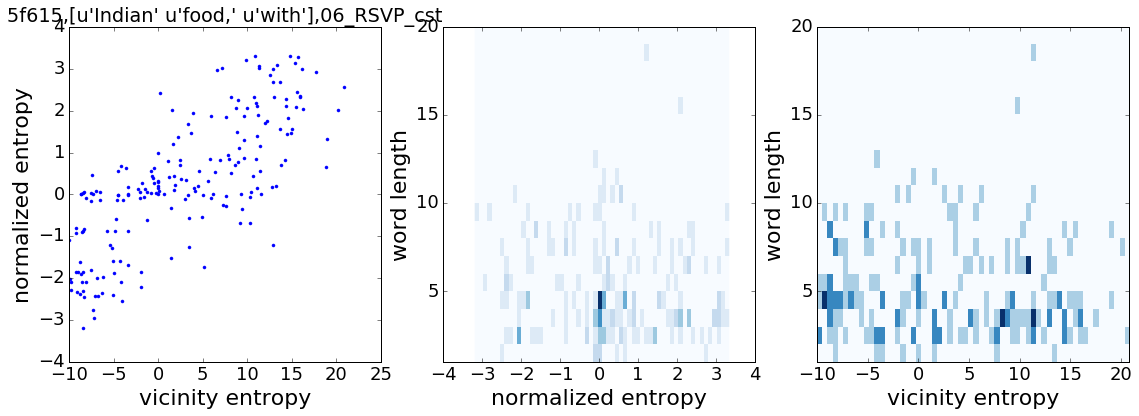

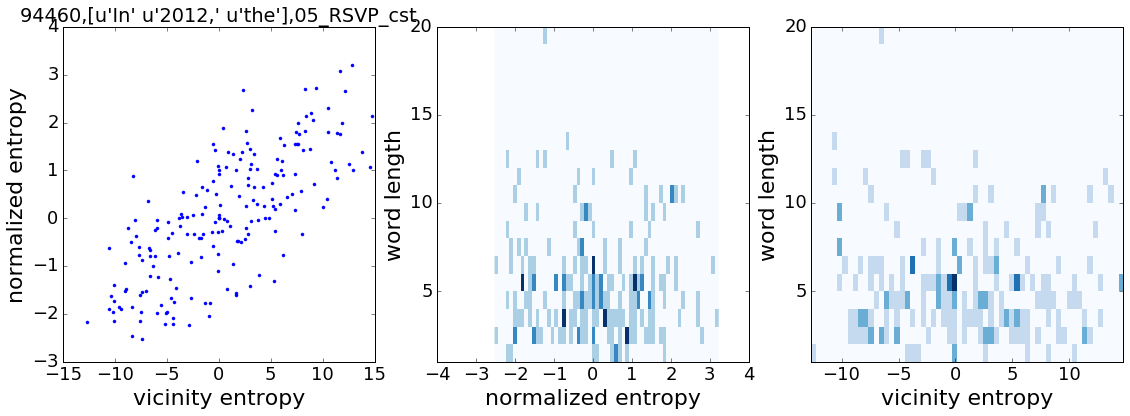

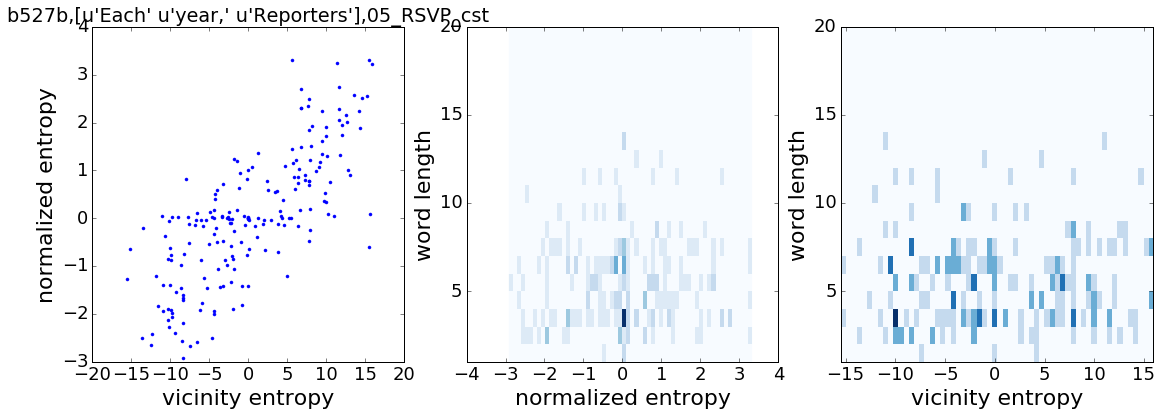

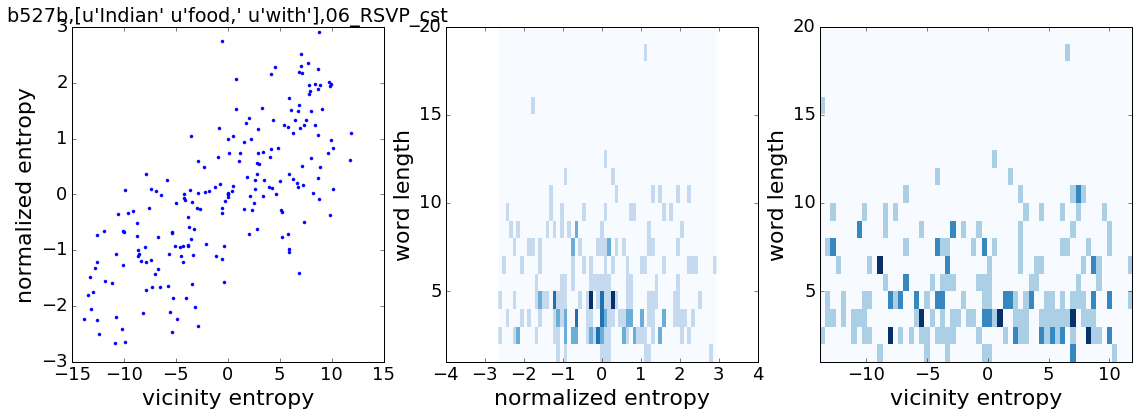

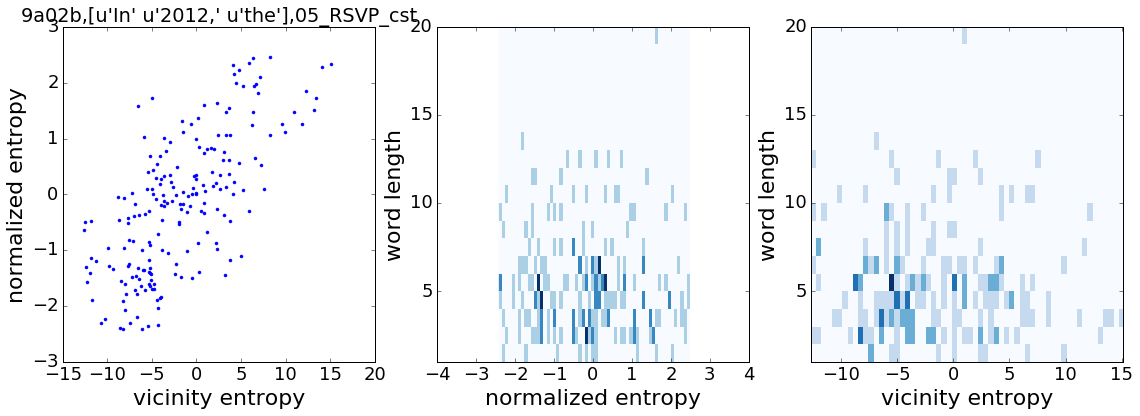

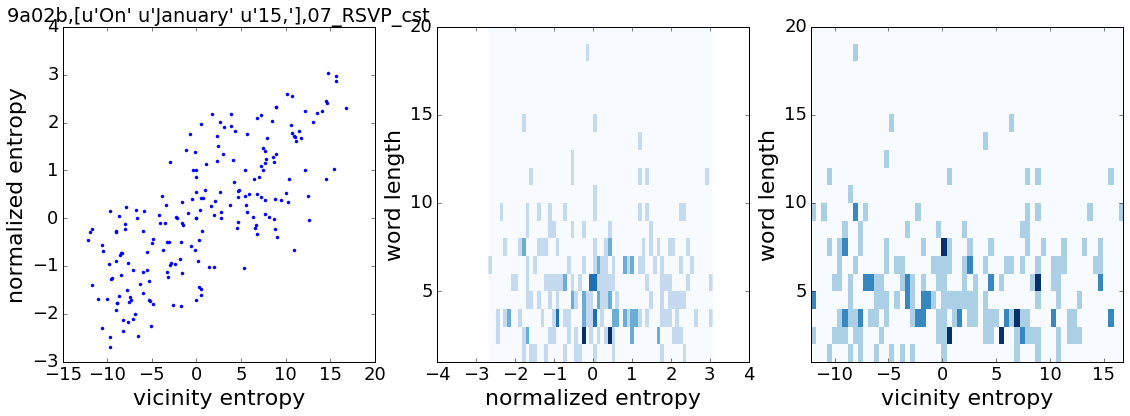

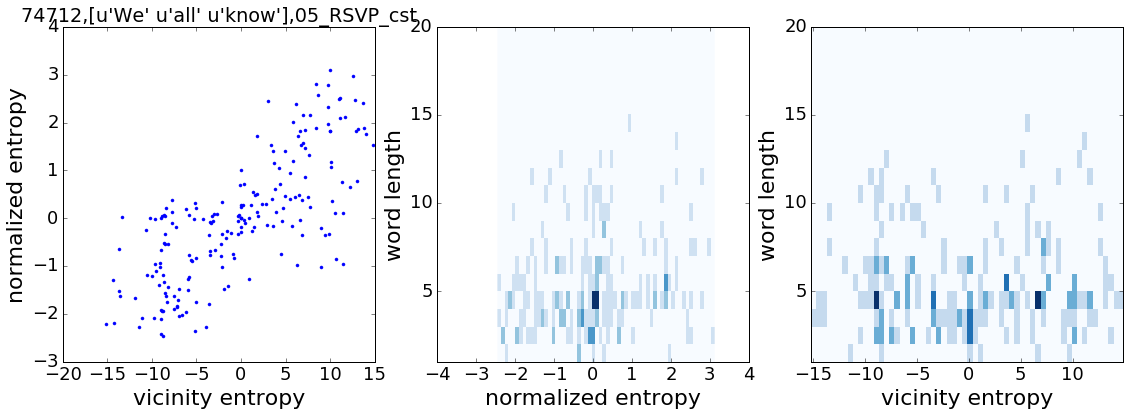

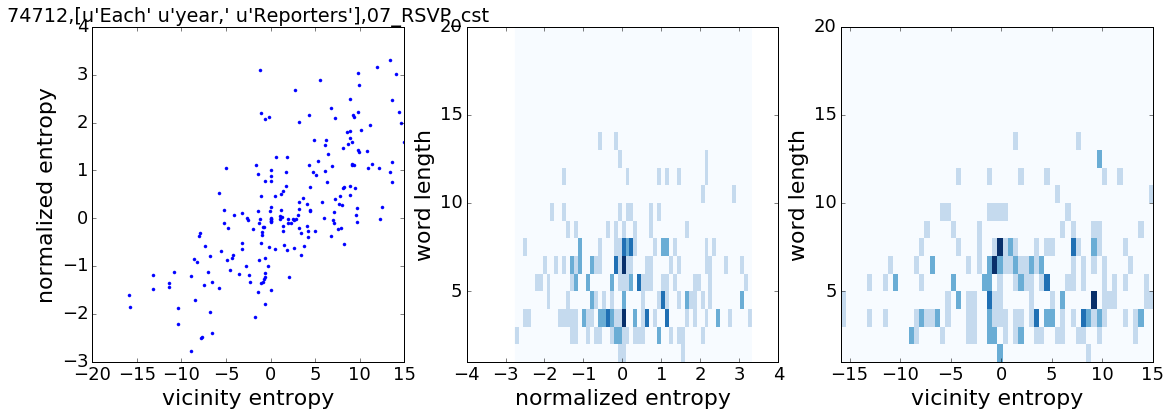

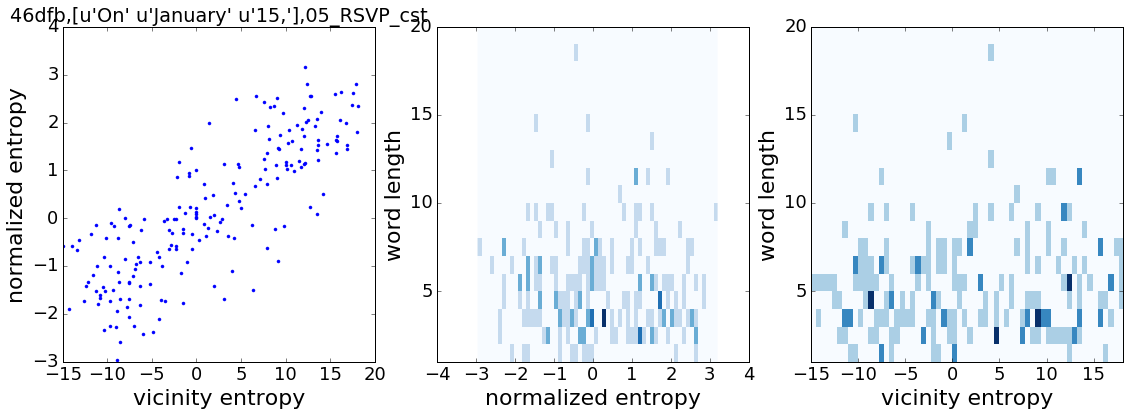

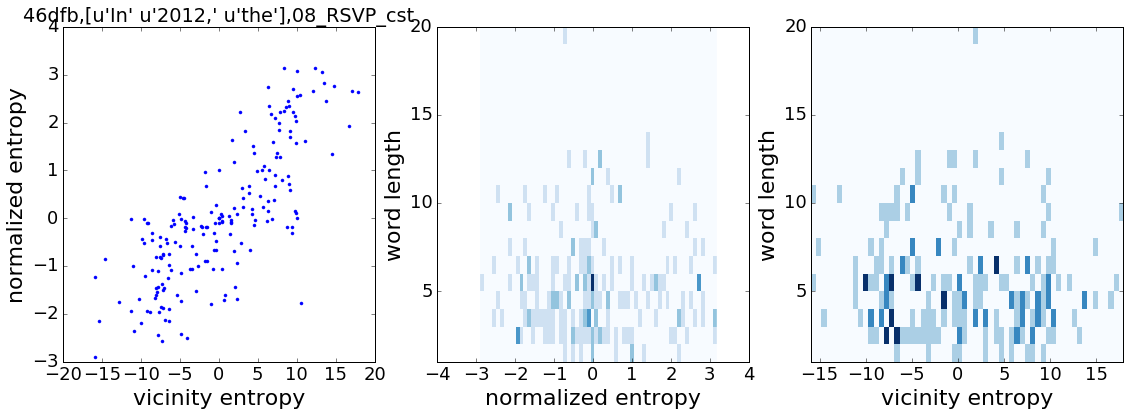

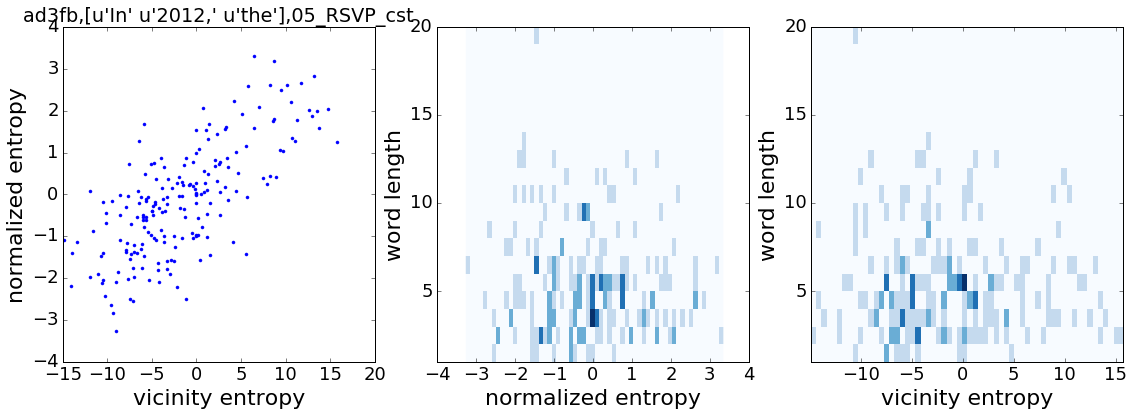

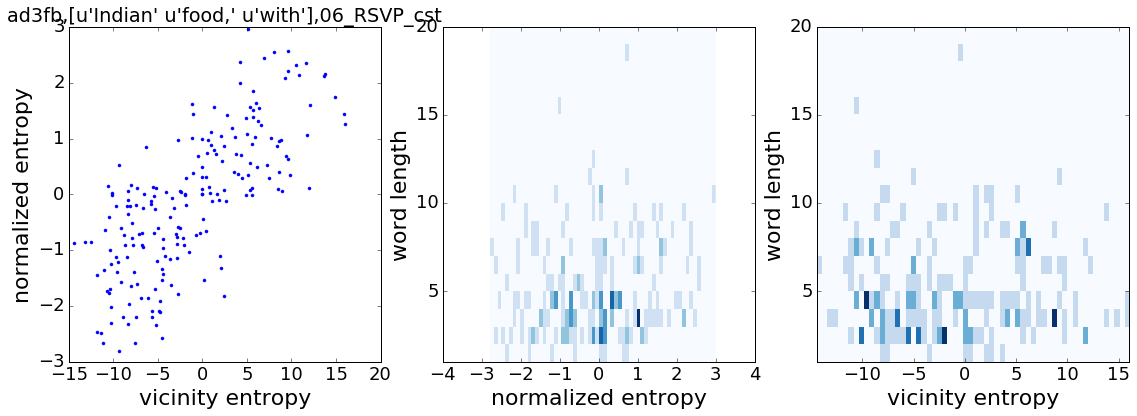

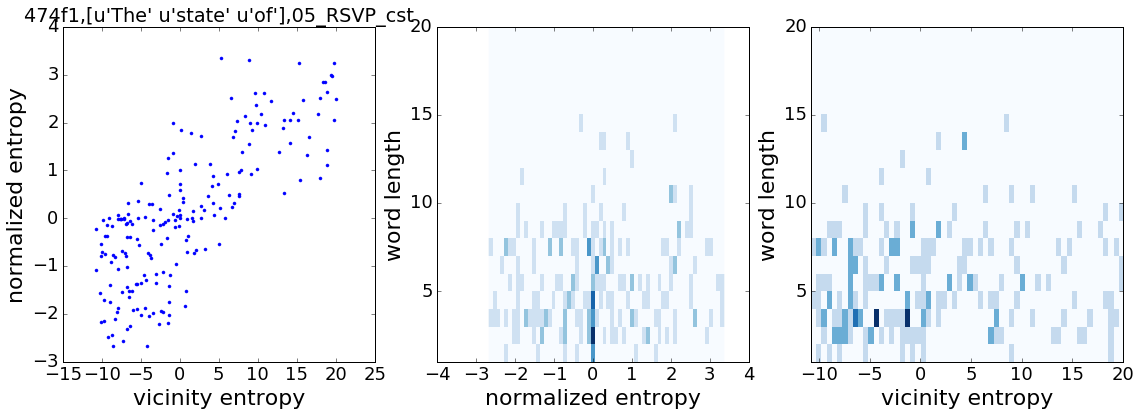

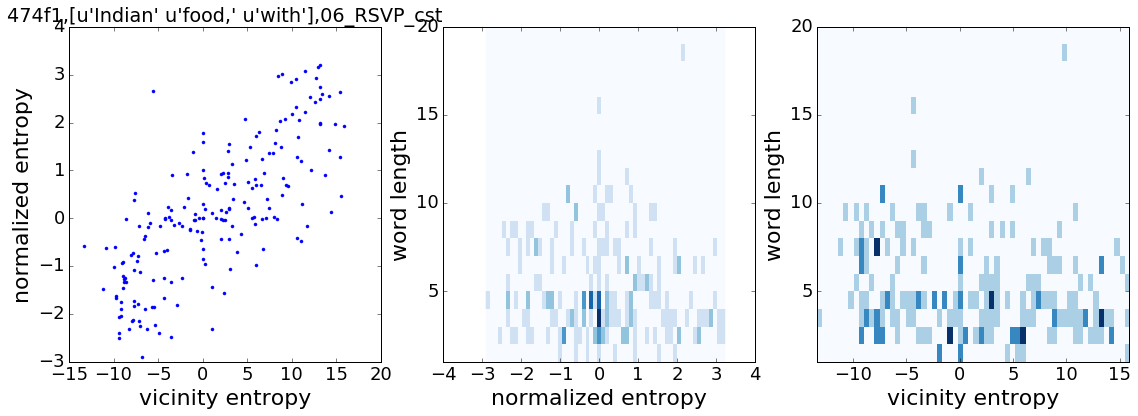

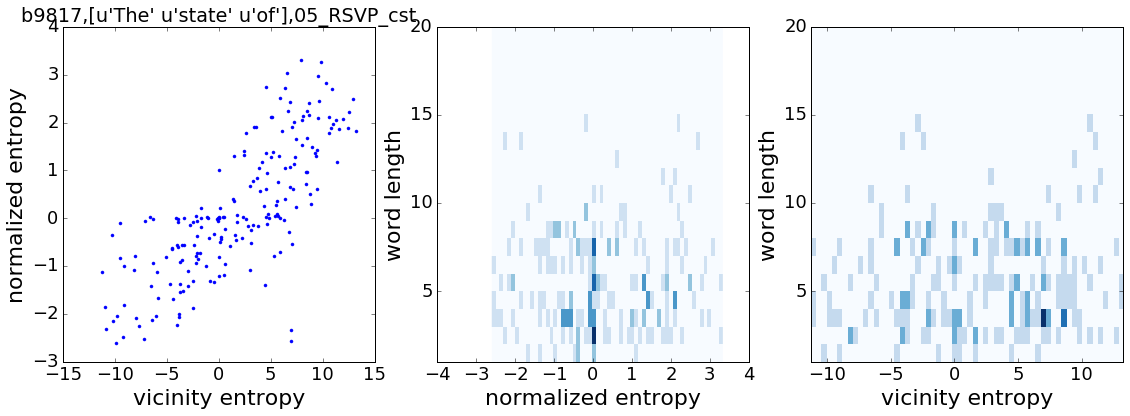

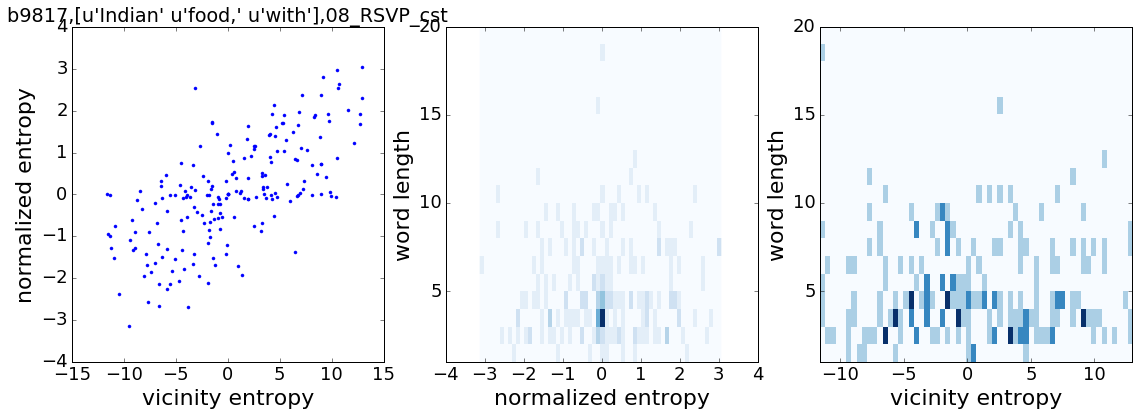

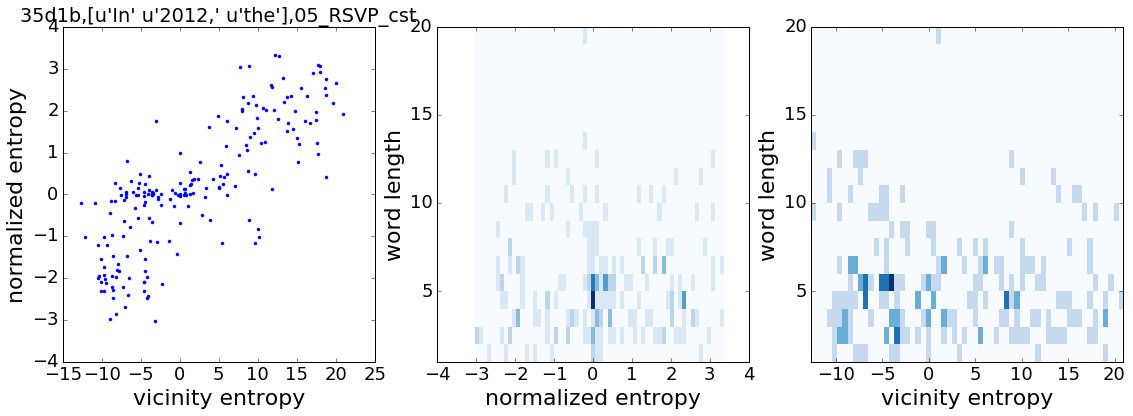

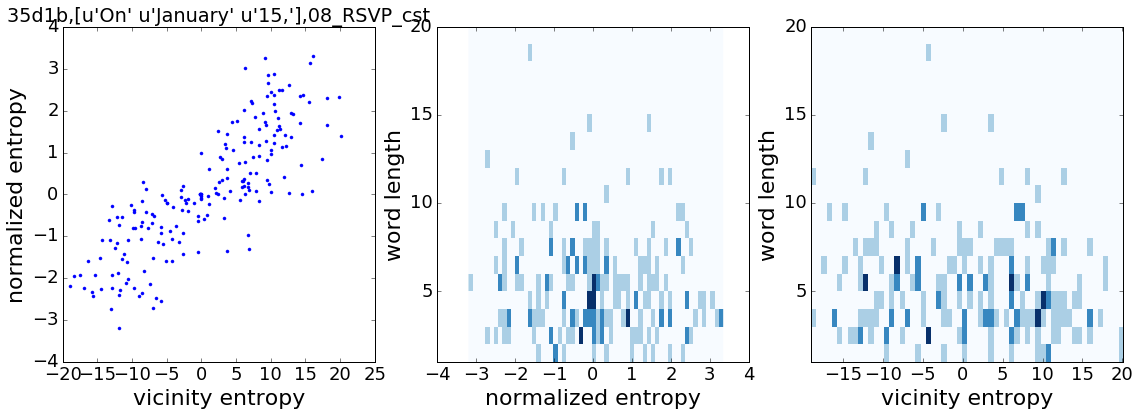

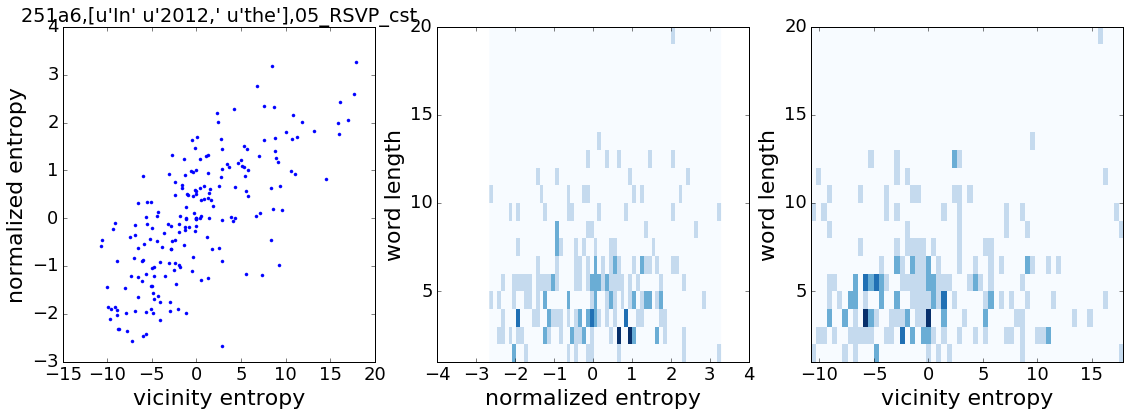

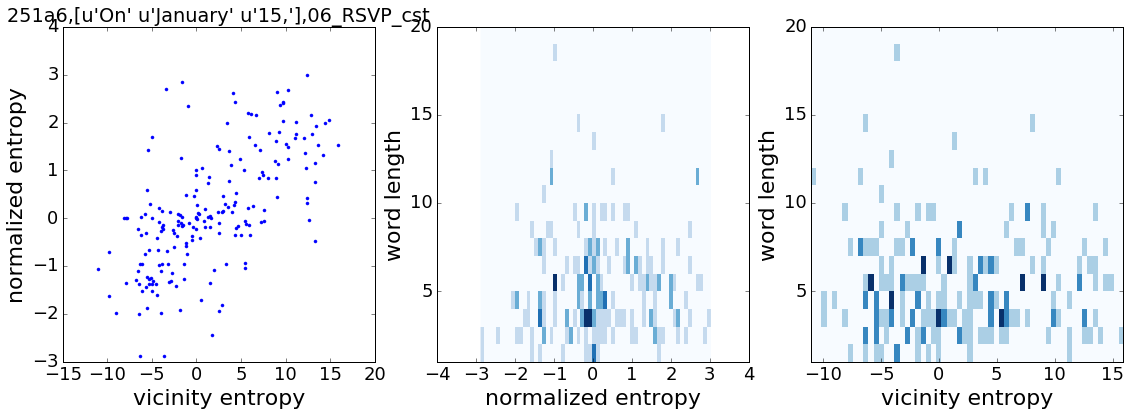

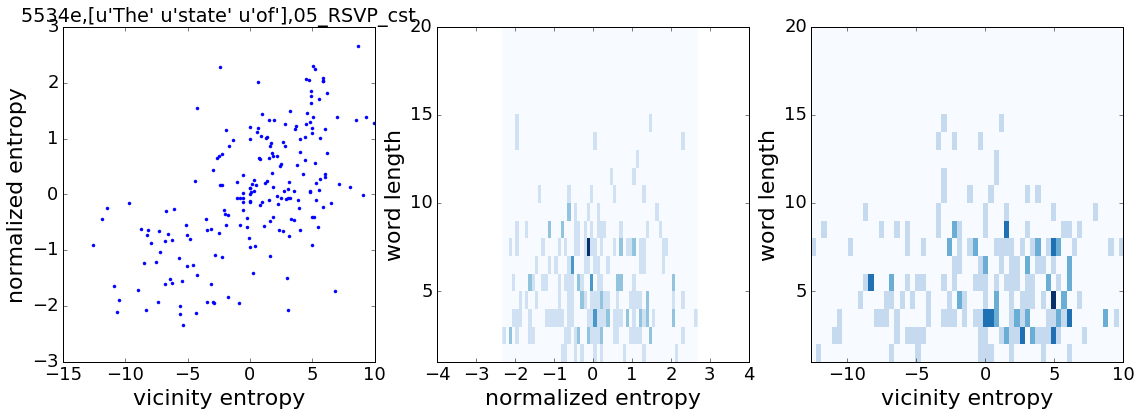

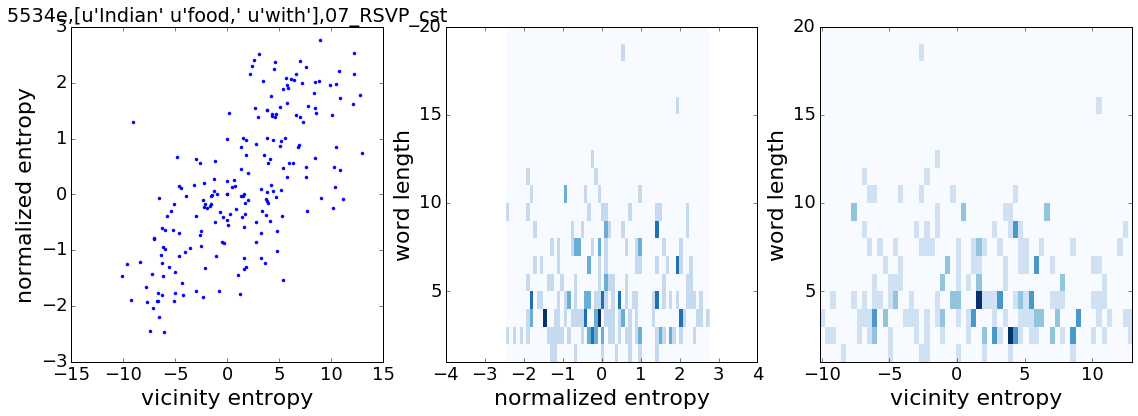

In [25]:
k = 0

SE = []
LW = []
W = []
SPLUS = []

lWordFootPrint = {}

for tk,token in enumerate(tokens):
    for treatment in [5,6,7,8]:
        try:
            J = allData[token]['J']
            Jlist = allData[token]['Jlist']
            #print Jlist

            words = np.array(J[Jlist[treatment]]['exp']['words'])[:-1]
            lWords = np.array([len(word) for word in words])
            
            if Jlist[treatment][3:] != "RSVP_cst":
                continue
                    
            #if words[1] != "In":
            #        continue
            
            lWordFootPrint[words[1]] = lWords
            
            sEntropy = np.array(J[Jlist[treatment]]['exp']['normalized_entropy'][:-1])
            sPlus = np.array([np.sum(sEntropy[i-5:i+5]) for i,ix in enumerate(sEntropy)])

            sEntropy = sEntropy[:200]
            sPlus = sPlus[:200]
            lWords = lWords[:200]
            words = words[:200]
            
            SE = np.append(SE,sEntropy)
            SPLUS = np.append(SPLUS,sPlus)
            LW = np.append(LW,lWords)
            W = np.append(W,words)
            
            k += 1
            
            pl.figure(k,(19,6))
            pl.subplot(131)
            pl.plot(sPlus,sEntropy,'.')
            pl.xlabel("vicinity entropy")
            pl.ylabel("normalized entropy")
            pl.title("%s,%s,%s"%(token,words[1:4],Jlist[treatment]))

            pl.subplot(132)
            H0 = generateJointPDF(lWords,sEntropy,plot=True)
            #pl.plot(sEntropy,lWords,'.')
            pl.ylabel("word length")
            pl.xlabel("normalized entropy")
            pl.xlim(-4,4)

            pl.subplot(133)
            #pl.plot(sPlus,lWords,'.')
            H0 = generateJointPDF(lWords,sPlus,plot=True)
            pl.ylabel("word length")
            pl.xlabel("vicinity entropy")
            #pl.xlim(-20,20)
            
            #pl.figure(k,(10,8))
            #H0 = generateJointPDF(lWords,sEntropy,plot=True)
        
        except:
            print "blah", Jlist[treatment]
            continue
    

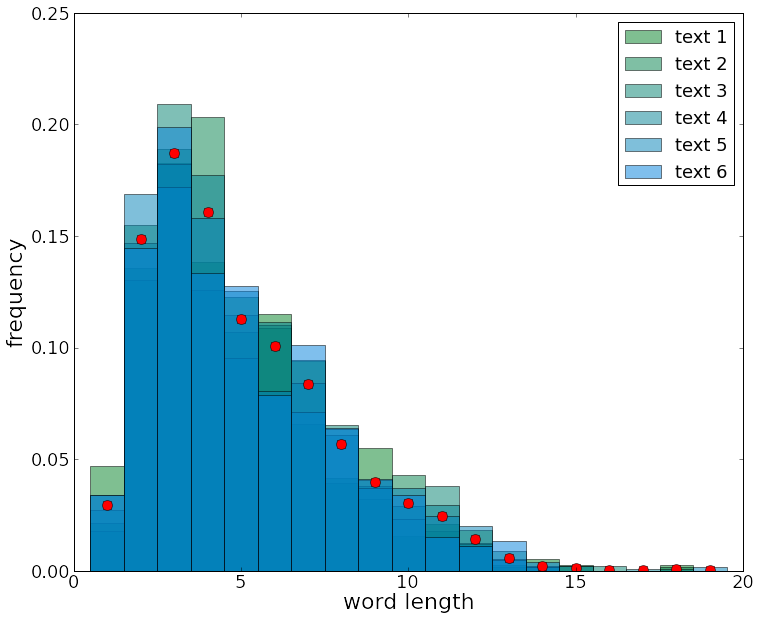

In [22]:
pl.figure(1,(12,10))

bins = np.arange(0,30)
nonParamPDF = np.zeros_like(bins)[:-1]

for i,(k,values) in enumerate(lWordFootPrint.items()):
    if k=="random":
        continue
    #print i,k
    H = np.histogram(values,bins=bins)
    pl.bar(H[1][:-1],H[0]/float(np.sum(H[0])),H[1][-1] - H[1][-2],align="center",
           alpha= 0.5,color = (0,0.5,(i+1)/7.),label="text %s"%(i+1))
    
    nonParamPDF = nonParamPDF + H[0]

nonParamPDF = nonParamPDF / float(np.sum(nonParamPDF))

c = nonParamPDF > 0

pl.plot(H[1][:-1][c],nonParamPDF[c],'ro',ms=10)

pl.ylim(ymax =0.25)
pl.xlim(xmin=0)
pl.xlabel("word length")
pl.ylabel("frequency")
pl.legend(loc=0)
pl.savefig(rootDir + "figures/word_density.eps")

In [20]:
l = len(lWordFootPrint.items())
print l,lWordFootPrint.keys()
segments = np.arange(10,380,25)
print segments

M = {}

m = np.zeros([l,l])

labels = []

for i,(ik,ivalues) in enumerate(lWordFootPrint.items()):
    labels.append(ik)
    for j,(jk,jvalues) in enumerate(lWordFootPrint.items()):
        if j >= i:
            continue
         
        print ik,len(ivalues),jk,len(jvalues)
        
        for s in segments:
            vi = 1./nonParamPDF[ivalues[:s]]
            vj = 1./nonParamPDF[jvalues[:s]]
        
            try:
                M[s][i,j] = cossim(vi,vj)
            except:
                M[s] = np.zeros([l,l])
                M[s][i,j] = cossim(vi,vj)

keys = np.sort(M.keys())
            
meanSim = []
stdSim = []

for s,sx in enumerate(keys):
    m = M[sx]
    #print np.mean(m[m>0]),np.std(m[m>0]),np.percentile(m[m>0],[5,95])
    meanSim = np.append(meanSim,np.mean(m[m>0]))
    stdSim = np.append(stdSim,np.std(m[m>0]))
    m[m==0] = None
    #print s,m
    
    
    #pl.figure(s)
    #pl.imshow(m[1:,:-1],interpolation="nearest",origin="lower",vmin=0.0,vmax=1.0)
    #pl.colorbar()
    #pl.savefig(rootDir + "figures/cossim_matrix%s.eps"%sx)

pl.figure(s+1,(9,9))
pl.semilogy(keys,meanSim,'o-',color="black",lw=2)
#pl.errorbar(keys,meanSim,yerr=stdSim,color="red")
#pl.plot(keys,meanSim - stdSim,'-.',color="black",lw=2)
#pl.plot(keys,meanSim + stdSim,':',color="black",lw=2)
#pl.fill_between(keys,meanSim - stdSim,meanSim + stdSim,color="grey",alpha=0.1)
#pl.plot(keys,meanSim - stdSim,'r-')
pl.xlabel("Sequence Length [words]")
pl.ylabel("Average Similarity")
pl.savefig(rootDir + "figures/similarity_vs_sLength.eps")

6 [u'On', u'We', u'Each', u'Indian', u'In', u'The']
[ 10  35  60  85 110 135 160 185 210 235 260 285 310 335 360]
We 561 On 383


NameError: name 'nonParamPDF' is not defined

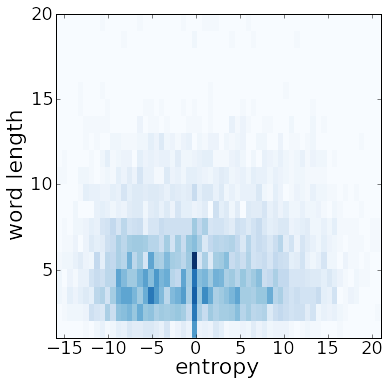

In [9]:
pdfDic = generateJointPDF(LW,SPLUS,plot=True)

85d6e
0 05_RSVP_cst Each
On
corr: 0.003 (0.567), npoints: 100.00
cossim: 0.005 (0.043) 0.123158435437
We
corr: 0.001 (0.504), npoints: 100.00
cossim: 0.003 (0.049) -0.0077326295771
Each
corr: 0.008 (0.522), npoints: 100.00
cossim: 0.011 (0.050) 0.0133131622944
Indian
corr: 0.001 (0.481), npoints: 100.00
cossim: 0.003 (0.055) 0.00289688151983
In
corr: 0.001 (0.535), npoints: 100.00
cossim: 0.003 (0.046) 0.104220588506
The
corr: -0.009 (0.478), npoints: 100.00
cossim: -0.005 (0.053) -0.260348255567
0 06_RSVP_bsrPlus On
On
corr: 0.048 (0.401), npoints: 100.00
cossim: 0.046 (0.057) -0.216756256453
We
corr: 0.001 (0.485), npoints: 100.00
cossim: -0.004 (0.054) -0.0667996411524
Each
corr: 0.029 (0.486), npoints: 100.00
cossim: 0.028 (0.051) 0.0241346098203
Indian
corr: -0.018 (0.483), npoints: 100.00
cossim: -0.018 (0.058) -0.203368590175
In
corr: -0.025 (0.474), npoints: 100.00
cossim: -0.025 (0.046) 0.278383123793
The
corr: 0.006 (0.520), npoints: 100.00
cossim: 0.007 (0.048) 0.46036276413

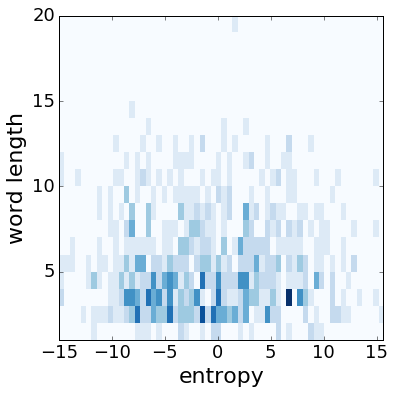

In [27]:
nPoints = 350
nBootstrap = 100

for tk,token in enumerate(['85d6e']):
#for tk,token in enumerate(tokens):
    
    print token
    for treatment in [5,6,7,8]:
        try:
            pattern = pullOut(token,treatment)
            pdfDic = generateJointPDF(pattern['lWords'],pattern['sPlus'],plot=True)
        except:
            print "blah"
            continue
          
        #if pattern['treatment'] != "RSVP_cst":
        #    continue

        print tk,pattern['treatment'],pattern['text']
    
        for k,v in  lWordFootPrint.items():
            #print k,v[:10]
            r = []
            p = []
            l = 0
            c = []

            for mcs in range(nBootstrap):
                v1 = pattern['sPlus'][:nPoints]
                v2 = np.array([randPickEntropy(lw,pdfDic) for lw in v[:nPoints]]) 
                c = np.append(c,cossim(v1,v2))

                rho = S.spearmanr(v1,v2)
                #if rho[1] < 0.05:
                r = np.append(r,rho[0])
                p = np.append(p,rho[1])
                l += 1 
            print k
            print "corr: %.3f (%.3f), npoints: %.2f"%(np.mean(r),np.mean(p),l)   
            print "cossim: %.3f (%.3f)"%(np.mean(c),np.std(c)), S.skew(c)

In [18]:
#token = "68cdc"
token = tokens[4]
treatment = 8

#nBootstrap = 100
pattern = pullOut(token,treatment)
print pattern['treatment'],pattern['text']

pl.figure(1,(21,7))
pl.subplot(131)
pdfDic = generateJointPDF(LW,SPLUS,plot=True)
pl.subplot(132)
pdfDic2 = generateJointPDF(pattern['lWords'],pattern['sPlus'],plot=True)

v = lWordFootPrint[pattern['text']]

nPoints = np.arange(1,250,10)

for k,v in  lWordFootPrint.items():
    
    if k=="random":
        continue
    x = []
    c = []
    
    print k
    for n in nPoints:
        v1 = pattern['sPlus'][:n]
        v2 = bootstrapDic[k][:n]
        try:
            x = np.append(x,n)
            c = np.append(c,cossim(v1,v2))
        except:
            continue

    try:
        pl.subplot(133)
        y = smooth(c,3)
        pl.plot(x,y,label=k)
    except:
        print len(x),len(c),len(y)
        pl.plot(x[:-1],y,label=k)
        
pl.xlabel("length [words]")
pl.ylabel("cossim")
pl.legend(loc=0)
pl.xlim(xmax=350)

KeyError: 'exp'

In [17]:
def makeBootstrap(lWordFootPrint,pdfDic,mcs=200):
    
    bootstrapDic = {}
    
    for k,v in  lWordFootPrint.items():
        print k
        v2 = np.zeros([nBootstrap,len(v)])
        for mcs in range(nBootstrap):
            v2[mcs] = np.array([randPickEntropy(lw,pdfDic) for lw in v])
        v2 = np.mean(v2,0)
        
        bootstrapDic[k] = v2
    
    return bootstrapDic

pdfDic = generateJointPDF(LW,SPLUS,plot=True)
bootstrapDic = makeBootstrap(lWordFootPrint,pdfDic,mcs=500)

NameError: name 'LW' is not defined

In [15]:
for k,v in  lWordFootPrint.items():
        print k,v[:10]

On [1 2 7 3 6 6 6 2 9 6]
We [ 1  2  3  4  2  6  3  4 12  2]
random [ 3  6  4 10  8 14 16  6 10  7]
Indian [ 1  6  5  4  3 10  2 11  3 12]
In [1 2 5 3 5 4 8 3 2 1]
The [1 3 5 2 3 6 8 4 4 2]
Each [1 4 5 9 7 7 6 1 9 7]


NameError: name 'lWordFootPrint' is not defined

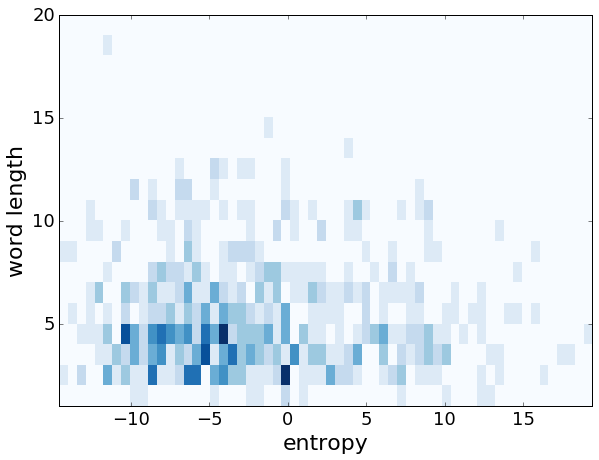

In [16]:
iterator = 0
for tk,token in enumerate(tokens):
    
    #print token
    for treatment in [5,6,7,8]:
        
        
        
        try:
            pattern = pullOut(token,treatment)
            #pdfDic = generateJointPDF(pattern['lWords'],pattern['sPlus'],plot=False)
        except:
            #print "blah"
            continue
          
        if pattern['treatment'][3:] != "RSVP_cst":
            continue

        #if pattern['text'] != "In":
        #    continue
            
        #print tk,pattern['treatment'],pattern['text']
        
        iterator +=1
        pl.figure(iterator,(21,7))
        #pl.subplot(131)
        #pdfDic = generateJointPDF(LW,SPLUS,plot=True)
        pl.subplot(121)
        pdfDic2 = generateJointPDF(pattern['lWords'],pattern['sPlus'],plot=True)
        
        nPoints = np.arange(1,250,1)

        for k,v in lWordFootPrint.items():
            
            x = []
            c = []
            
            if k=="random":
                continue

    
            #print k
            
            for n in nPoints:
                v1 = pattern['sPlus'][:n]
                v2 = bootstrapDic[k][:n]
                try:
                    x = np.append(x,n)
                    c = np.append(c,cossim(v1,v2))
                except:
                    continue

            pl.subplot(122)
            pl.semilogx(x,c,label=k)
            
            '''
            try:
                pl.subplot(133)
                y = smooth(c,3)
                pl.plot(x,y,label=k)
            except:
                print len(x),len(c),len(y)
                pl.plot(x[:-1],y,label=k)
            '''

        pl.subplot(122)
        pl.title("%s,%s,%s"%(token,pattern['treatment'],pattern['text']))
        pl.xlabel("length [words]")
        pl.ylabel("cossim")
        pl.legend(loc=0)
        pl.xlim(0,350)

In [555]:
token = '92647'
treatment = 7
J = allData[token]['J']
Jlist = allData[token]['Jlist']
words = np.array(J[Jlist[treatment]]['exp']['words'])[:-1]

lWords = np.array([len(word) for word in words])
sEntropy = np.array(J[Jlist[treatment]]['exp']['normalized_entropy'][:-1])
sPlus = np.array([np.sum(sEntropy[i-5:i+5]) for i,ix in enumerate(sEntropy)])


o = np.arange(len(SPLUS))
np.random.shuffle(o)
lWordFootPrint['random'] = np.random.randint(1,19,300)

span = 100
mcsteps = 100

#print LW[o][:5]
#print W[o][:5]
#m,scores = decipher(SPLUS[o],lWordFootPrint,pdfDic,length=span,mcsteps = mcsteps)

print words[0:5],Jlist[treatment]
print lWords[0:5]
m,scores = decipher(sPlus,lWordFootPrint,pdfDic,length=span,mcsteps = mcsteps)


dic = {}

for k,v in scores.items():
    L = lWordFootPrint[k][:span+1]
    l = len(L[L < 4])
    print "%s, %s, score: %.3f(%.3f) %.3f"%(k,l,np.mean(v,0)[-1],np.std(v,0)[-1],np.max(v,0)[-1])
    print (np.mean(v,0)[-1] / dicRandom[k])*100
    dic[k] = np.mean(v,0)[-1]

[u'x' u'Indian' u'food,' u'with' u'its'] 07_RSVP_bsrMinus
[1 6 5 4 3]
On, 41, score: 0.826(0.031) 0.882
100.378474388
We, 35, score: 0.840(0.024) 0.900
99.7232244701
random, 19, score: 0.783(0.054) 0.899
95.2874944959
Indian, 46, score: 0.834(0.027) 0.887
100.492692722
In, 36, score: 0.837(0.027) 0.889
100.720219022
The, 39, score: 0.826(0.029) 0.900
100.047750087
Each, 32, score: 0.850(0.032) 0.912
100.425695843


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in double_scalars


In [192]:
pl.imshow?

In [74]:
dicRandom = dic.copy()

In [78]:
dicRandom

{u'Each': 0.84647262668950229,
 u'In': 0.83091374859915534,
 u'Indian': 0.83036411573650459,
 u'On': 0.82322586981041379,
 u'The': 0.82577901917254293,
 u'We': 0.84242967602794705,
 'random': 0.82221964975034012}

In [95]:
for ik,iv in lWordFootPrint.items():
    for jk,jv  in lWordFootPrint.items():
        
        if ik==jk:
            continue
        #print "\n"
        print ik,jk
        
        #for l in [25,50,100,200]:
        for l in [100]:    
            c = (iv[:l] < 5)*(jv[:l] < 5)
            
            sim1 = len(np.argwhere(iv[:l]==jv[:l]))
            sim2 = cossim(iv[:l][c],jv[:l][c])
            #print "%s, %s, %.2f;"%(l,sim,float(sim)/l),
            print "%s, %.2f, %.2f;"%(l,sim2,float(sim2)/l)
            #print ik,jk,"%.3f %.3f %.3f %.3f %.3f"%(cossim(iv[:25],jv[:25]),cossim(iv[:50],jv[:50]),cossim(iv[:50],jv[:50]),cossim(iv[:100],jv[:100]),cossim(iv[:200],jv[:200]))

On We
100, 0.89, 0.01;
On In
100, 0.92, 0.01;
On random
100, 0.93, 0.01;
On Indian
100, 0.93, 0.01;
On Each
100, 0.94, 0.01;
On The
100, 0.87, 0.01;
We On
100, 0.89, 0.01;
We In
100, 0.91, 0.01;
We random
100, 0.85, 0.01;
We Indian
100, 0.93, 0.01;
We Each
100, 0.89, 0.01;
We The
100, 0.91, 0.01;
In On
100, 0.92, 0.01;
In We
100, 0.91, 0.01;
In random
100, 0.90, 0.01;
In Indian
100, 0.91, 0.01;
In Each
100, 0.92, 0.01;
In The
100, 0.93, 0.01;
random On
100, 0.93, 0.01;
random We
100, 0.85, 0.01;
random In
100, 0.90, 0.01;
random Indian
100, 0.79, 0.01;
random Each
100, 0.95, 0.01;
random The
100, 0.84, 0.01;
Indian On
100, 0.93, 0.01;
Indian We
100, 0.93, 0.01;
Indian In
100, 0.91, 0.01;
Indian random
100, 0.79, 0.01;
Indian Each
100, 0.92, 0.01;
Indian The
100, 0.90, 0.01;
Each On
100, 0.94, 0.01;
Each We
100, 0.89, 0.01;
Each In
100, 0.92, 0.01;
Each random
100, 0.95, 0.01;
Each Indian
100, 0.92, 0.01;
Each The
100, 0.89, 0.01;
The On
100, 0.87, 0.01;
The We
100, 0.91, 0.01;
The In
1

In [34]:
print len(t1),len(t2)

t1 = lWordFootPrint.values()[0]
t2 = lWordFootPrint.values()[1]

0


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.
  if __name__ == '__main__':


LinregressResult(slope=0.32073140765753522, intercept=-0.29473046306944806, rvalue=0.29405646958907472, pvalue=0.28740911891189846, stderr=0.28913500284155474)


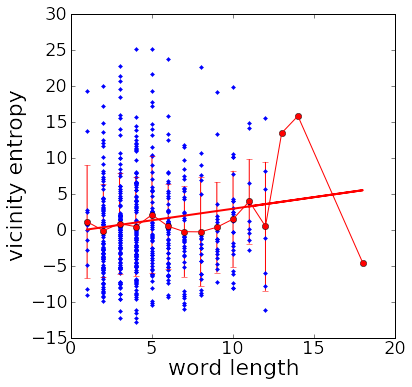

In [127]:
B = binning(lWords,sPlus,30)
fitB = S.linregress(B['bins'],B['mean'])
print fitB

pl.plot(lWords,sPlus,'.')
pl.plot(B['bins'],B['mean'],'ro')
pl.plot(lWords,lWords*fitB[0] + fitB[1],'r-',lw=2)
pl.errorbar(B['bins'],B['mean'],yerr=B['stdDev'],color="red")


pl.xlabel("word length")
pl.ylabel("vicinity entropy")

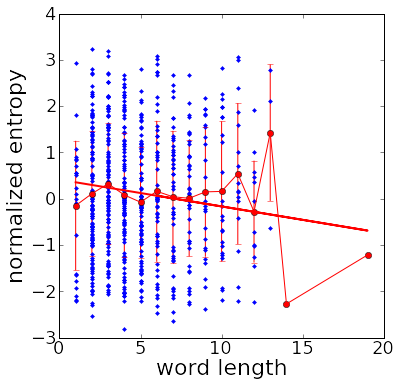

In [121]:
B = binning(lWords,sEntropy,30)
fitB = S.linregress(B['bins'],B['mean'])
pl.plot(lWords,sEntropy,'.')
pl.plot(B['bins'],B['mean'],'ro')
pl.plot(lWords,lWords*fitB[0] + fitB[1],'r-',lw=2)
pl.errorbar(B['bins'],B['mean'],yerr=B['stdDev'],color="red")

pl.ylabel("normalized entropy")
pl.xlabel("word length")

In [97]:
iSmall = np.argwhere(lWords <=1)
iLarge = np.argwhere(lWords >= 9)

print np.mean(sEntropy[iSmall+6]),np.std(sEntropy[iSmall]),len(sEntropy[iSmall])
#print np.mean(sEntropy[iLarge-4]),np.std(sEntropy[iSmall]),len(sEntropy[iLarge])

-0.000862819914649 1.14219395086 8


In [74]:
iSmall = np.argwhere(sEntropy < np.percentile(sEntropy,10))
iLarge = np.argwhere(sEntropy > np.percentile(sEntropy,90))

print np.mean(sEntropy[iSmall]),np.std(sEntropy[iSmall]),len(sEntropy[iSmall])
print np.mean(sEntropy[iLarge]),np.std(sEntropy[iSmall]),len(sEntropy[iLarge])

-1.45283510084 0.350919258525 45
2.89295839441 0.350919258525 45


In [68]:
np.mean(lWords[iLarge])

5.3555555555555552

In [14]:
i = 0

firstWord = ["We","Each","The","In","Indian","On"]
bins = np.linspace(-5,5,21)


dic = {}
data = []

X = []
Xtrain = []

y = []
ytrain = []

yW = []
yWtrain = []

for token in tokens:
    Jlist = allData[token]['Jlist']
    J = allData[token]['J']
    
    k = 0
    
    for treatment in range(len(Jlist)):

        #if Jlist[treatment][3:7] != "RSVP":
        #    continue

        if Jlist[treatment][3:] != "RSVP_cst":
            continue

        
        
        k+=1            
                #try:
        words = np.array(J[Jlist[treatment]]['exp']['words'])[:-1]
        lWords = np.array([len(word) for word in words])
        sEntropy = np.array(J[Jlist[treatment]]['exp']['normalized_entropy'][:-1])
    
        #if words[1] != firstWord[4]:
        #    continue
        
            
        #print token,Jlist[treatment][3:],words[:7]
    
        mw = np.mean(lWords)
        minPerc,maxPerc =  np.percentile(lWords,[15,95])
        
        smallWordIndex = np.argwhere(lWords < minPerc)
        largeWordIndex = np.argwhere(lWords > maxPerc)
        
        sSmall = sEntropy[smallWordIndex]
        sLarge = sEntropy[largeWordIndex]
 
        numbins = 20
        Hw = np.histogram(lWords,bins = numbins)
        H = np.histogram(sEntropy,bins = bins)
        
        data.append([token,words[1],H[0],Hw[0]])
        
        if k <= 3:
            ytrain = np.append(ytrain,token)
            yWtrain = np.append(yWtrain,words[1])

            try:
                Xtrain = np.vstack([Xtrain,H[0]])
            except:
                Xtrain = H[0]            

        else:
            y = np.append(y,token)
            yW = np.append(yW,words[1])

            try:
                X = np.vstack([X,H[0]])
            except:
                X = H[0]            

            
            
print len(X),len(y),len(yW)

RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
RSVP_cst
0 0 0


In [146]:
clf = svm.SVC()
clf.fit(Xtrain, ytrain)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [148]:
print np.array(y)
print clf.predict(X)

['8db55' '8db55' '8db55' '68cdc' 'b527b' '9a02b' '74712']
['5f615' '5f615' '5f615' 'ac3ef' '85d6e' '29979' 'f62ff']


In [257]:
simVsame = []
simVdifferent = []

simTsame = []
simTdifferent = []

simV = []
simT = []

vSame = []
tSame = []

for i,line1 in enumerate(data):
    #print "\n"
    v1 = line1[2]
    t1 = line1[3]

    for j,line2 in enumerate(data):
        if j >= i:
            continue
        
        #if line1[0] == line2[0]:
        #    continue
        
        #if line1[1] == line2[1]:
        #    continue
            
        v2 = line2[2]
        t2 = line2[3]
        #print v2
        
        simv = np.sum(v1*v2) / (np.sqrt(np.sum(v1**2))*np.sqrt(np.sum(v2**2)))
        simText = np.sum(t1*t2) / (np.sqrt(np.sum(t1**2))*np.sqrt(np.sum(t2**2)))
        
        simV = np.append(simV,simv)
        simT = np.append(simT,simText)
        
        
        
        if line1[0] == line2[0]:
            vSame = np.append(vSame,1)
            #simVsame.append(simv)
        else:
            vSame = np.append(vSame,0)
            #simVdifferent.append(simv)

        if line1[1] == line2[1]:
            tSame = np.append(tSame,1)
            #simTsame.append(simText)
        else:
            tSame = np.append(tSame,0)
            #simTdifferent.append(simv)
            
        #print "[%s,%s] [%s,%s] = %.4f (%.4f)"%(line1[0],line1[1],line2[0],line2[1],simv,simText)

In [258]:
len(tSame)

231

3 conditions:

* same user | same text (no record for this)
* same user | different text => 0.981


* same user | textSim < 0.90 => 0.981
* same user | textSim > 0.90 => 0.981
* same user | textSim > 0.98 => 0.984


* different user | same text => 0.961
* different user | different text => 0.959

* different user | textSim < 0.9 => 0.957
* different user | textSim > 0.9 => 0.961
* different user | textSim > 0.98 => 0.959

In [179]:
np.linspace(0.8,1,41)

array([ 0.8  ,  0.805,  0.81 ,  0.815,  0.82 ,  0.825,  0.83 ,  0.835,
        0.84 ,  0.845,  0.85 ,  0.855,  0.86 ,  0.865,  0.87 ,  0.875,
        0.88 ,  0.885,  0.89 ,  0.895,  0.9  ,  0.905,  0.91 ,  0.915,
        0.92 ,  0.925,  0.93 ,  0.935,  0.94 ,  0.945,  0.95 ,  0.955,
        0.96 ,  0.965,  0.97 ,  0.975,  0.98 ,  0.985,  0.99 ,  0.995,  1.   ])

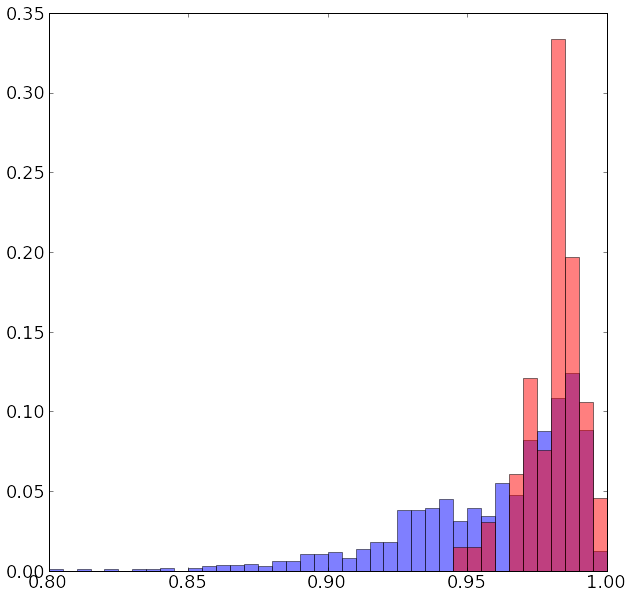

In [180]:
numbins = 20
bins = np.linspace(0.8,1,41)
pl.figure(1,(10,10))
#pl.subplot(122)
Hdifferent = np.histogram(simVdifferent,bins = bins)
pl.bar(Hdifferent[1][:-1],Hdifferent[0]/float(np.sum(Hdifferent[0])),Hdifferent[1][-1] - Hdifferent[1][-2],color='b',alpha=0.5)
#pl.plot(Hdifferent[1][:-1],Hdifferent[0]/float(np.sum(Hdifferent[0])),'b-')

#pl.subplot(121)
Hsame = np.histogram(simVsame,bins = bins)
pl.bar(Hsame[1][:-1],Hsame[0]/float(np.sum(Hsame[0])),Hsame[1][-1] - Hsame[1][-2],color='r',alpha=0.5)
#pl.plot(Hsame[1][:-1],Hsame[0]/float(np.sum(Hsame[0])),'r-')